to make more readable: 

create variables of common subsets,  
functions 

In [214]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns 
import scipy
import math
import random 
from scipy import stats
import statistics
import math 

### first up: processing

In [215]:
random.seed(1)

In [216]:
drop_cols = ['Unnamed: 0', 'Allowed', 'Subject', 'StudioVersion', 'leftarrow', 'rightarrow', 'triggercode',
            'Clock.Information', 'DataFile.Basename', 'Display.RefreshRate', 'ExperimentName', 
            'Procedure[Block]', 'Procedure[Trial]', 'RandomSeed', 'Running[Block]', 'Running[SubTrial]', 
            'Running[Trial]', 'RuntimeCapabilities', 'RuntimeVersion', 'RuntimeVersionExpected']


In [217]:
#this makes it so that the WHOLE dataframe prints, just fyi, this can bog down your code

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

In [218]:
SST_concat = pd.read_csv('SST_cleaned_7231_all_rows_all_columns.csv').drop(drop_cols, axis =1)

/Users/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,15,38,82,105,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### then, a few qa checks: 

In [219]:
#check these values - they shouldn't be over 1000ms 
sum(SST_concat['go_stim_duration'] > 1000)

0

In [220]:
#check len - should be 2mil 
assert len(SST_concat) == 2603160

In [ ]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectGo'])

In [221]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectGo'])

1864544

In [222]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectStop'])

221501

In [223]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectStop'])

212359

In [ ]:
#assertion about stop_rt_adjusted and go_rt_adjusted

In [ ]:
#build in a few more here - for trial code correctness and 

### Issue 1:  Different go stimulus duration across trials

mean duration go stimulus on go trials - all trials 

In [226]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'])

566.8983810445766
221.8583268472381


221.85837798265038

mean duration go stimulus on stop trials

In [227]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'])

226.26519845111326
151.63924909734422


151.6394238536057

difference of these

In [228]:
np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']) \
    - np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna())

340.6331825934633

plot to show how drastic this is

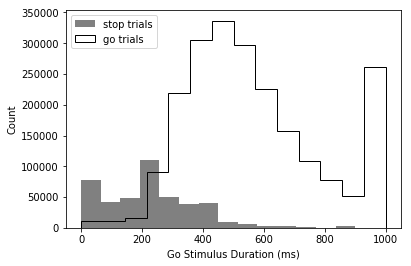

In [265]:
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna(), bins = 14, label = "stop trials", color = 'grey')
plt.xlabel('Go Stimulus Duration (ms)')
#plt.title('Go Stimulus Duration')
plt.ylabel('Count')

#SSDUR.value_counts()
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'].dropna(), bins = 14, histtype='step',\
          label = "go trials", color = 'black')
#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
plt.legend(loc='upper left')#, bbox_to_anchor=(1.0, 1.00), shadow=True, ncol=1)
plt.savefig('go_stim_duration.pdf')
plt.show()

mean go.rt vs. mean stop failure & how many subjects mean stop failure is longer than mean rt 

stop failure RT - all trials

In [230]:
np.mean(SST_concat.loc[SST_concat['correct_stop'] == 0]['stop_rt_adjusted'])

480.87264500398555

overt go response rt - all trials 

In [231]:
np.mean(SST_concat.loc[SST_concat['correct_go_response'] != 'omission']['go_rt_adjusted'])

541.8450486026431

let's look at the averages by participant now: 

In [232]:
group_narguid = SST_concat.groupby('NARGUID')

In [233]:
narguid_stop_duration = group_narguid.apply(lambda x: np.mean(x.loc[x['trial_type'] == 'StopTrial']['go_stim_duration']))

In [234]:
np.std(narguid_stop_duration)

113.0951312064794

In [235]:
narguid_go_duration = group_narguid.apply(lambda x: np.mean(x.loc[x['trial_type'] == 'GoTrial']['go_stim_duration']))

In [236]:
np.std(narguid_go_duration)

102.12584632751773

In [237]:
np.mean(narguid_go_duration) - np.mean(narguid_stop_duration)

340.6331825934649

stop failure RT - by participant 

In [238]:
#lambda x lets us apply np.mean to each group
narguid_average_stop_rt = group_narguid.apply(lambda x: \
                                                np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))
np.mean(narguid_average_stop_rt)

495.01266545367145

go rt - by participant

In [239]:
narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') \
                                                                    & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))
print('mean:', np.mean(narguid_average_go_rt))
print('sdev:', np.std(narguid_average_go_rt))

mean: 543.6630781157475
sdev: 95.29722256609477


context violations -  

In [240]:
print(sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)))
sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / 7231

1326


0.18337712626192781

In [241]:
def stop_fail_accuracy(df):
    try: 
        acc = len(df.loc[df['correct_stop_mapping'] == 1]) / len(df.loc[df['correct_stop'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    return acc                                         

In [242]:
narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt,'go_rt':narguid_average_go_rt})

narguid_df['stop_acc'] = np.NaN
narguid_df['go_acc'] = np.NaN

narguid_df['go_acc'] = group_narguid.apply(lambda x: len(x.loc[x['correct_go_response'] == '1.0']) /
                                          len(x.loc[(x['correct_go_response'] != 'omission') & (x['trial_type'] == 'GoTrial')]))

narguid_df['stop_acc'] = group_narguid.apply(lambda x: stop_fail_accuracy(x))
narguid_df = narguid_df.dropna(how='any')
#this doesn't have three participants who had perfect stop accuracy

CIs

In [243]:
mu = np.mean(narguid_df['go_rt'] - narguid_df['stop_rt'])
N = len(narguid_df)
sigma = np.std(narguid_df['go_rt'] - narguid_df['stop_rt'])
stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N))


(46.559456555770865, 50.76564197295882)

In [244]:
from scipy.stats import ttest_rel, ttest_ind, norm
ttest_rel(narguid_df['stop_rt'], narguid_df['go_rt']) 

Ttest_relResult(statistic=-45.3476185819303, pvalue=0.0)

accuracies

In [245]:
mu = np.mean(narguid_df['stop_acc'] - narguid_df['go_acc'])
N = len(narguid_df)
sigma = np.std(narguid_df['stop_acc'] - narguid_df['go_acc'])
stats.norm.interval(.95, loc=mu,scale=sigma/math.sqrt(N))

(-0.11187416423722574, -0.10639848790163689)

In [246]:
ttest_rel(narguid_df['stop_acc'], narguid_df['go_acc'])

Ttest_relResult(statistic=-78.12312416962492, pvalue=0.0)

##### choice accuracy across SSDs 

In [247]:
ssd_acc_df = group_narguid.apply(lambda x: x.groupby('SSDDur').apply(lambda x: stop_fail_accuracy(x))) 

In [248]:
average_ssd_acc = ssd_acc_df.groupby('SSDDur').apply(lambda x: np.mean(x))

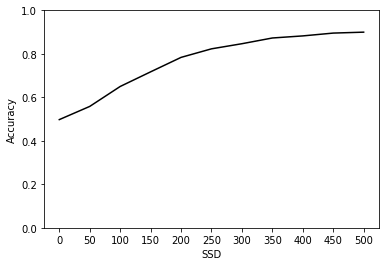

In [270]:
plt.plot(average_ssd_acc.iloc[:-8], color='black')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 550, 50))
plt.ylabel('Accuracy')
plt.xlabel('SSD')
plt.savefig('accuracy_accross_ssd.pdf')
plt.show()


### Issue 2: Go Stimulus sometimes not presented

percentage of trials with SSD == 0, and therefor, no go stimulus

In [271]:
len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

0.09017194486700779

rt on these trials

In [272]:
np.mean(SST_concat.loc[SST_concat['SSDDur'] == 0]['stop_rt_adjusted'])

195.91493277439804

percent of accuracy when SSD == 0 

In [273]:
def zero_SSD_acc(df): #this can eventually be ocmbined with stop fial acc 
    try: 
        acc = len(df.loc[(df['SSDDur'] == 0) & (df['correct_stop'] == 1.0)]) / len(df.loc[df['SSDDur'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    
    return acc                     

In [274]:
zero_acc = group_narguid.apply(lambda x: zero_SSD_acc(x))

In [275]:
np.mean(zero_acc)

0.6045009332058497

In [276]:
#needs to be be changed to narguid accuracies
len(SST_concat.loc[(SST_concat['SSDDur'] == 0) & (SST_concat['correct_stop'] == 1.0)])/ \
    len(SST_concat.loc[SST_concat['SSDDur'] == 0])

0.38103880169725474

### Issue 5: Non-uniform conditional trial probabilities

In [277]:
x = np.arange(0,20, 1)
def my_dist(i):
    i = (1/6) * (5/6)**(i)
    return(i)
p = my_dist(x)
p_norm = p/np.sum(p)  # norm to sum=1
p_cdf = np.cumsum(p_norm) # cumulative distribution
nsamples = 1000000
p_samp = []
rng = np.random.RandomState(1)
for i in range(nsamples):
    idx = np.where(p_cdf > rng.rand())[0]
    if len(idx) == 0:
        idx = p_cdf.shape[0] - 1
    else:
        idx = idx[0]
    p_samp.append(idx)

In [253]:
stop_prob_index = SST_concat.loc[(SST_concat['StopTrial'] !=1) & (SST_concat['StopTrial'] !=31)].index

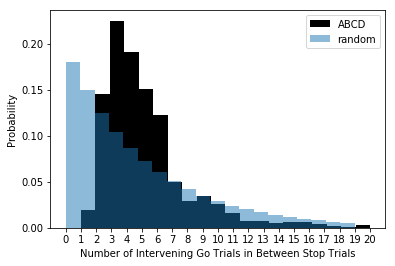

<Figure size 432x288 with 0 Axes>

In [261]:
plt.hist(SST_concat['Stop_nback'].loc[stop_prob_index].dropna(), density = True, bins = 20, label = 'ABCD', color = 'black')
p_norm = p/np.sum(p)  # norm to sum=1
#plt.plot(x,p_norm, label = ‘random conditional probability of a stop signal’, color=‘r’)
ax = plt.gca()
plt.hist(p_samp, density = True, bins = 20, label = 'random', alpha=0.5)

plt.xlabel('Number of Intervening Go Trials in Between Stop Trials')
plt.ylabel('Probability')
#plt.title('Non-uniform conditional trial probabilities')
plt.xticks(np.arange(0, 21, step=1))
plt.legend()
plt.savefig('conditional_probability.pdf')
plt.show()


conditional probability of a stop signal, given a stop signal occured two trials ago

In [ ]:
def mean_nback(df): 
    stop_prob_index = df.loc[(df['StopTrial'] !=1) & (df['StopTrial'] !=31)].index
    df = df.loc[stop_prob_index]
    nback =len(df.loc[df['Stop_nback'] == 1]) / len(df.loc[df['trial_type'] == 'StopTrial'])
    return nback

In [ ]:
mean_one_nback = group_narguid.apply(lambda x: mean_nback(x))

In [ ]:
np.mean(mean_one_nback)

In [ ]:
one_back = SST_concat.loc[SST_concat['Stop_nback'] == 1] #stop nback in this case 
stop_nback = SST_concat.loc[~SST_concat['Stop_nback'].isnull()]['Stop_nback']
print("percent of trials with stop signals sepreated by one go trial:", len(one_back) / len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'] )) 
#this num changed when re-ran with better indexing for selecting stop trials 

##### post stop slowing? 

In [204]:
SST_concat.loc[(SST_concat['StopTrial'] == 30)]['TrialNum'].value_counts()
SST_concat.loc[(SST_concat['StopTrial'] == 60)]['TrialNum'].value_counts()

359    3551
358    1650
352     604
355     586
356     574
360     266
Name: TrialNum, dtype: int64

to do - exclude omissions, comissions, and cross-run 

In [ ]:
def calc_post_stop_slowing(df): 
    """
    helpful noets here - takes awhilel to run 
    """
    stop_slowing_df = pd.DataFrame()

    #this is definitely not the most efficient way to do this
    stop_mask = df.loc[df['trial_type'] == 'StopTrial']
    stop_idx = stop_mask[stop_mask == True].index

    df['correct_go_response'].replace('omission', np.NaN, inplace=True)
    df['correct_go_response'].replace('0.0', np.NaN, inplace=True)
    #get the pre-stop rt
    stop_slowing_df['StopTrial'] = df['StopTrial'][stop_idx]
    stop_slowing_df['TrialNum'] = df['TrialNum'][stop_idx]    

    stop_slowing_df['pre_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx - 1]) #find trial before stop signal
    stop_slowing_df['pre_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx - 1]) #find trial before stop signal


    stop_slowing_df['post_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_minus_pre'] = stop_slowing_df['post_stop_rt'] - stop_slowing_df['pre_stop_rt']
    
    first_quartile_mean = np.mean(stop_slowing_df.iloc[:15].loc[(stop_slowing_df['TrialNum'] != '1')].dropna(how='any')['post_minus_pre'])
    
    second_quartile_mean = np.mean(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != '180') & (stop_slowing_df['TrialNum'] != '181')].iloc[15:30].dropna(how='any')['post_minus_pre'])
    
    third_quartile_mean = np.mean(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != '180') & (stop_slowing_df['TrialNum'] != '181')].iloc[30:45].dropna(how='any')['post_minus_pre'])
    
    fourth_quartile_mean = np.mean(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != '360')].iloc[45:60].dropna(how='any')['post_minus_pre'])
 
    quartile_list =[first_quartile_mean, second_quartile_mean, third_quartile_mean, fourth_quartile_mean]
    print(quartile_list)
    return quartile_list

In [ ]:
quartile = group_narguid.apply(lambda x: calc_post_stop_slowing(x))

In [ ]:
first = []
second = []
third = [] 
fourth = [] 
for i in range(len(quartile)): 
    first.append(quartile[i][0])
    second.append(quartile[i][1])
    third.append(quartile[i][2])
    fourth.append(quartile[i][3])

In [ ]:
quartiles.to_csv('quartiles_means.csv')

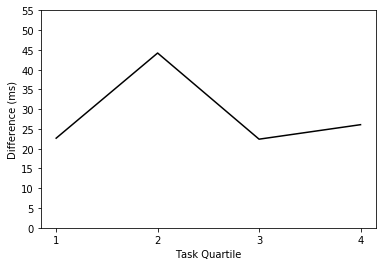

In [266]:
plt.plot(np.arange(1, 5, 1), [np.nanmean(first), np.nanmean(second), np.nanmean(third), np.nanmean(fourth)], color='black')
#plt.title('Post-Stop-Trial Slowing')
#plt.errorbar(np.arange(1, 5, 1), [np.nanmean(first), np.nanmean(second), np.nanmean(third), np.nanmean(fourth)], yerr=)
plt.ylabel('Difference (ms)')
plt.xlabel('Task Quartile')
plt.xticks([1, 2, 3, 4])
plt.yticks(np.arange(0,60,5))
plt.savefig('task_quartile_slowing.pdf')
plt.show() #needs error bars?  


#### Issue 4: Different stop signal stimulus duration for different SSDs

In [ ]:
len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / 433860 #get rid of the hardcoding 

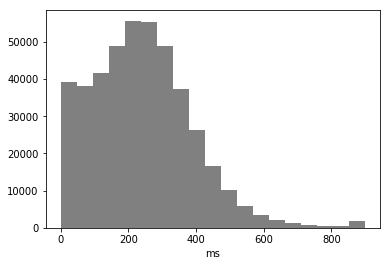

In [267]:
plt.hist(SST_concat['SSDDur'].dropna(), bins = len(SST_concat['SSDDur'].dropna().unique()), color='grey')
plt.xlabel('ms') #fix xlabel, ylabel 
#plt.title('Distribution of Stop Signal Delays')

#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
#plt.legend()
plt.savefig('stop_signal_duration_hist.pdf')
plt.show() #needs error bars 


#### Issue 3: SSD can become stuck at 0ms 


In [ ]:
#uncomment to look at the relevant columns 
# SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]\
#      [['NARGUID', 'TrialNum', 'SSD.RT', 'SSD.RESP', 'SSDDur' ]]

In [ ]:
pd.DataFrame(SSD_bug.unique()).to_csv('SSD_bug.csv')

In [ ]:
SSD_bug = SST_concat.loc[(SST_concat['SSD.RT'] < 50) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID']# \

In [ ]:
len(SSD_bug.unique())/ 7231  #percent of subjects with this issue 

In [ ]:
len(SSD_bug) / len(SST_concat) #percent of trials this impacts 

In [ ]:
len(SST_concat['NARGUID'].unique()) - len(SSD_bug.unique() * 360)

In [ ]:
len(SST_concat.set_index('NARGUID').drop(SSD_bug.unique()).index.unique()) #check this syntax drops all of the narguids for these participants 

In [ ]:
SST_concat.set_index('NARGUID').drop(SSD_bug.unique())

In [ ]:
drop_zero_ssd_group = SST_concat.set_index('NARGUID').drop(SSD_bug.unique()).groupby('NARGUID') #a little convoluted, but drops the prob barguids and regroups 

In [ ]:
len(drop_zero_ssd_group)

In [ ]:
drop_zero_acc = drop_zero_ssd_group.apply(lambda x: zero_SSD_acc(x))

In [ ]:
np.mean(drop_zero_acc)

#### Issue 6: Trial accuracy incorrectly coded

In [ ]:
#move from other notebook 

#### Issue 7: SSD values start too short 


In [255]:
num_stop = []
accuracy = [] 
mean_ssd = [] 
for i in np.arange(1, 61): 
    correct = SST_concat.loc[SST_concat['StopTrial'] ==i]['correct_stop'].value_counts()[1]
    acc = correct / len(SST_concat.loc[SST_concat['StopTrial'] ==i])
    ssd = np.mean(SST_concat.loc[SST_concat['StopTrial'] == i]['SSDDur'])
 
    num_stop.append(i)
    accuracy.append(acc)
    mean_ssd.append(ssd)
    
acc_df = pd.DataFrame() 
acc_df['StopTrial'] = num_stop 
acc_df['Accuracy'] = accuracy
acc_df['SSD'] = mean_ssd

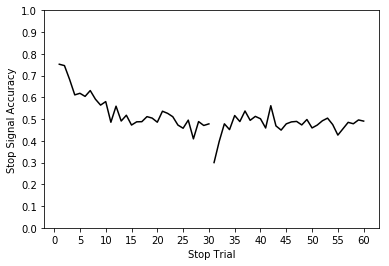

In [268]:
plt.plot(acc_df['StopTrial'][:30], acc_df['Accuracy'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['Accuracy'][30:], color='black')

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Accuracy')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.yticks(np.arange(0,1.1, .1))
plt.xticks(np.arange(0,61,5))
plt.savefig('stop_signal_accuracy_across_stop_trial.pdf')
plt.show() #needs error bars 


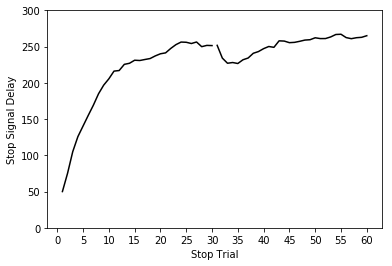

In [269]:
plt.plot(acc_df['StopTrial'][:30], acc_df['SSD'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['SSD'][30:], color='black')

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Delay')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.xticks(np.arange(0,61,5))
plt.yticks(np.arange(0, 350, 50))
plt.savefig('ssd_across_stop_trial.pdf')
plt.show()


#### Issue 8: Low stop probability 

speaks for itself?